# **Digital Signal and Image Management - E02**<br/>
**Master's Degree in Data Science (A.Y. 2022/2023)**<br/>
**University of Milano - Bicocca**<br/>

prof. Simone Bianco, 
dr. Marco Buzzelli

In [325]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd # Notebook only

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

**Note:**
* Before continuing, you must import this file into your own Google Drive:<br/>https://drive.google.com/file/d/1w9l6WnU-oQ-8IsY1NSRcWNulqcQ5DHFK/view?usp=sharing<br/>(Top-right corner -> Add shortcut to Drive -> My Drive -> Add shortcut here)
* If the link no longer works, you can retrieve the original dataset from:<br/>https://github.com/Jakobovski/free-spoken-digit-dataset

In [326]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [327]:
# Import file
sound_rate, sound_data = wav.read('recordings/0_jackson_0.wav')
# Play the signal
ipd.Audio(sound_data, rate=sound_rate)

In [328]:
# Shape of the audio array: 5148 values, one dimension
sound_data.shape

(5148,)

In [329]:
# Sampling rate: 8000 samples per second
sound_rate

8000

## Data representation

### Temporal representation

In [330]:
# Convert sample index into the corresponding timestamp, for the plot x-axis
sound_time = np.arange(sound_data.shape[0])*1.0/sound_rate

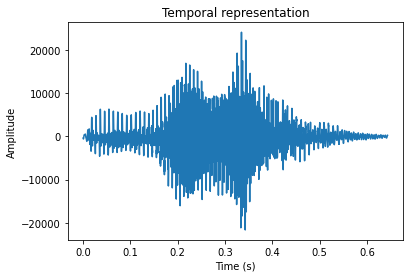

In [331]:
# Visualizing a signal (temporal representation)
plt.plot(sound_time, sound_data);
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Temporal representation')
plt.show()

https://numpy.org/doc/stable/reference/generated/numpy.arange.html<br/>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

**Note:**
* This is a direct representation of how audio tracks are commonly stored, i.e. in temporal representation.
  * A vector of values that continually oscillates from positive to negative, changing in amplitude.
* By knowing the sampling rate, we can provide an accurate x-axis for the visualization:
  * If the audio represents 8000 samples per second, we want the 8000th sample to correspond to be labeled as "1" second.
  * So we generate all sample indices, and then divide each sample index by 8000.

### Frequency representation (Fast Fourier Transform)

In [332]:
# Conversion into the frequency domain
sound_fft = fft(sound_data)
sound_freqs = fftfreq(len(sound_data), 1.0/sound_rate)

In [333]:
# Shape of the temporal representation
sound_data.shape

(5148,)

In [334]:
# Shape of the frequency representation
sound_fft.shape

(5148,)

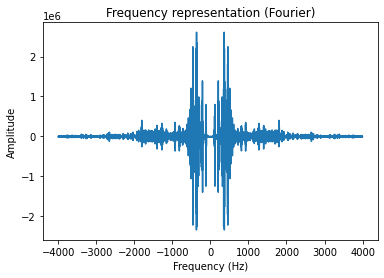

In [335]:
# Visualizing a signal (frequency representation)
plt.plot(sound_freqs, np.real(sound_fft));
plt.xlabel('Frequency (Hz)');
plt.ylabel('Amplitude')
plt.title('Frequency representation (Fourier)')
plt.show()

**Note**:
* Similarly as with the temporal representation, we can provide an accurate x-axis for the plot, although this time we rely on an external function `fftfreq()`.
  * The values returned by `fftfreq()` are "out of order": if you directly plot `sound_fft` without proper x-axis, you can see in which order the original vector is computed: frequencies 0 to 4000Hz, and then frequencies -4000Hz to 0.
* For real-valued input data (as is our case), the discrete Fourier transform will always return a symmetric output.
  * For many practical applications, therefore, we can use the `rfft()` variant, which returns only half the frequency spectrum.
  * The `np.real(sound_fft)` used when plotting refers to the fact that the *output* is in practice real, although the computation generates complex data, so we want to keep only the real part.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html<br/>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html

In [336]:
# Conversion into the frequency domain for real input data
sound_rfft = rfft(sound_data)
sound_rfreqs = rfftfreq(len(sound_data), 1.0/sound_rate)

In [337]:
# Shape of the frequency representation
sound_rfft.shape

(2575,)

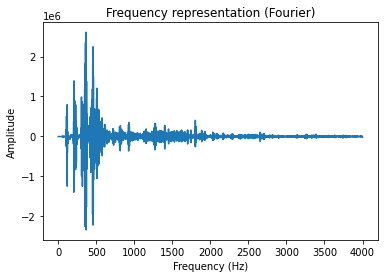

In [338]:
# Visualizing the frequency signal
plt.plot(sound_rfreqs, np.real(sound_rfft));
plt.xlabel('Frequency (Hz)');
plt.ylabel('Amplitude')
plt.title('Frequency representation (Fourier)')
plt.show()

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.rfft.html<br/>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.rfftfreq.html

### Temporal/Frequency representation (Spectrogram)

In [339]:
# Spectrogram computation (with default parameters)
[spec_freqs, spec_times, spec] = spectrogram(sound_data, fs=sound_rate)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html<br/>

**Note:**
* The spectrogram is computed by splitting the audio track into segments, and computing the Fourier transform individually for each segment (instead of once on the whole track).
  * This is why you end up with an additional dimension:
  * For each time segment (column), you have its own Fourier description (rows).
* This is sometimes also called a Short-Term Fourier Transform
* The time segments can have different size, and different overlaps.
  * We are using default parameters, which are determined automatically with a heuristic.

In [340]:
# Shape of the output spectrogram
np.array(spec).shape

(129, 22)

In [341]:
# Frequency values associated to the 129 rows of `spec`
spec_freqs

array([   0.  ,   31.25,   62.5 ,   93.75,  125.  ,  156.25,  187.5 ,
        218.75,  250.  ,  281.25,  312.5 ,  343.75,  375.  ,  406.25,
        437.5 ,  468.75,  500.  ,  531.25,  562.5 ,  593.75,  625.  ,
        656.25,  687.5 ,  718.75,  750.  ,  781.25,  812.5 ,  843.75,
        875.  ,  906.25,  937.5 ,  968.75, 1000.  , 1031.25, 1062.5 ,
       1093.75, 1125.  , 1156.25, 1187.5 , 1218.75, 1250.  , 1281.25,
       1312.5 , 1343.75, 1375.  , 1406.25, 1437.5 , 1468.75, 1500.  ,
       1531.25, 1562.5 , 1593.75, 1625.  , 1656.25, 1687.5 , 1718.75,
       1750.  , 1781.25, 1812.5 , 1843.75, 1875.  , 1906.25, 1937.5 ,
       1968.75, 2000.  , 2031.25, 2062.5 , 2093.75, 2125.  , 2156.25,
       2187.5 , 2218.75, 2250.  , 2281.25, 2312.5 , 2343.75, 2375.  ,
       2406.25, 2437.5 , 2468.75, 2500.  , 2531.25, 2562.5 , 2593.75,
       2625.  , 2656.25, 2687.5 , 2718.75, 2750.  , 2781.25, 2812.5 ,
       2843.75, 2875.  , 2906.25, 2937.5 , 2968.75, 3000.  , 3031.25,
       3062.5 , 3093

In [342]:
# Time values associated to the 22 columns of `spec`
spec_times

array([0.016, 0.044, 0.072, 0.1  , 0.128, 0.156, 0.184, 0.212, 0.24 ,
       0.268, 0.296, 0.324, 0.352, 0.38 , 0.408, 0.436, 0.464, 0.492,
       0.52 , 0.548, 0.576, 0.604])

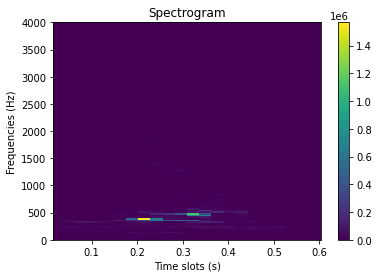

In [343]:
# Spectrogram visualization
plt.imshow(spec, extent=[spec_times[0], spec_times[-1], spec_freqs[0], spec_freqs[-1]], origin='lower', aspect='auto', interpolation='nearest')
plt.xlabel('Time slots (s)')
plt.ylabel('Frequencies (Hz)')
plt.title('Spectrogram')
plt.colorbar()
plt.show()

https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html<br/>
https://matplotlib.org/stable/tutorials/intermediate/imshow_extent.html<br/>
https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_aspect.html<br/>
https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html

**Note:**
* Having two dimensions, we can visualize the spectrogram as an image.
* For the sake of precision, we are providing additional information to the `imshow()` function:
  * `extent`: specifies the range of the x and y axes, instead of using integer indices starting from 1.
  * `aspect` (`'auto'`): even though the two axes have different order of magnitudes, they are stretched so that they are both visible.
  * `interpolation`: whether and how to smooth the data for visualization (not used here).

### Temporal/Frequency representation (Mel Spectrogram)

In [344]:
# Mel spectrogram computation (with default parameters)
mel = melspectrogram(y=sound_data*1.0, sr=sound_rate)

https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html

In [345]:
# Shape of the resulting Mel spectrogram
mel.shape

(128, 11)

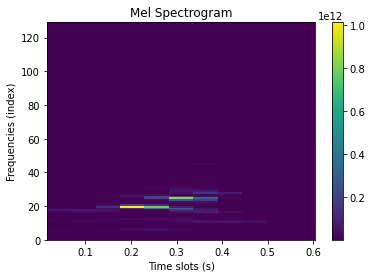

In [346]:
# Mel spectrogram visualization
plt.imshow(mel, extent=[spec_times[0], spec_times[-1], 0, 129], origin='lower', aspect='auto', interpolation='nearest')
plt.xlabel('Time slots (s)')
plt.ylabel('Frequencies (index)')
plt.title('Mel Spectrogram')
plt.colorbar()
plt.show()

**Note:**
* The Mel representation accounts for the fact that we (humans) do not perceive frequencies linearly.
* A Mel spectrogram is computed by redistributing Hertz frequencies into Mel frequencies using an appropriate matrix multiplication.
* The `melspectrogram` function can also be invoked by providing as input a regular spectrogram.
* To display the Mel spectrogram with accurate y-axis values, we resort to a built-in librosa function `specshow`.

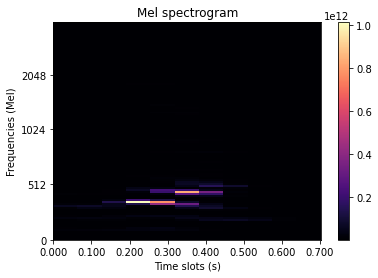

In [347]:
# Mel spectrogram visualization (with librosa)
specshow(mel, x_axis='time', y_axis='mel', sr=sound_rate)
plt.xlabel('Time slots (s)')
plt.ylabel('Frequencies (Mel)')
plt.title('Mel spectrogram')
plt.colorbar()
plt.show()

https://librosa.org/doc/latest/generated/librosa.display.specshow.html

### Cepstral representation (MFCC)
MFCC: Mel-Frequency Cepstral Coefficients

In [348]:
# MFCC computation with default parameters
mfccs = mfcc(sound_data*1.0, sr=sound_rate)

In [349]:
# Shape of the resulting MFCC matrix
mfccs.shape

(20, 11)

https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html

**Note:**
* The MFCC coefficients are based on the Fourier description of a Mel spectrogram (which, in turn, was obtained via Fourier analysis)
  * We are **not** applying the inverse Fourier transform, rather applying Fourier twice
  * Additional transformations are involved, such as logarithmic scaling.
* The result is still a two-dimensional matrix:
  * The first dimension size (20) depends on the choice of the frequencies/coefficients.
  * The second dimension size (11) depends on the duration of the audio track.

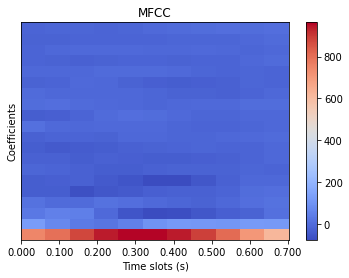

In [350]:
# Visualization via librosa's specshow
specshow(mfccs, sr=sound_rate, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()

**Note:**
* You may observe that lower coefficients have a strong dominance over high coefficients.
* We can, at least for visualization, normalize each "row" (a coefficient) by its own statistics.
  * Note that this is different from the normalization that we use in feature extraction for classification, although the concept is similar.

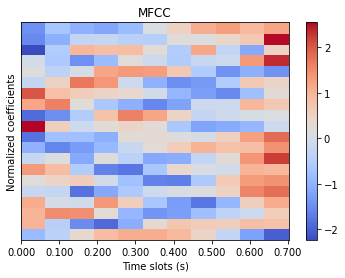

In [351]:
# Scaled visualization
from sklearn.preprocessing import scale
mfccs2 = scale(mfccs, axis=1)
specshow(mfccs2, sr=sound_rate, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Normalized coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()

## Classification

### Data loading

In [352]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

### Temporal features

In [353]:
def feats_temporal(input, size=1000):
    # Remove any values exceeding the given limit
    output = input[0:min(size, input.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

**Note:**
* Whatever feature we use, we must make sure that all audios have the same feature length.
* This is naturally a problem when it depends on the (variable) duration in seconds.
* Here we are arbitrarily truncating all audio tracks to the first 1000 samples, and adding any shorter track with zeros until it reaches 1000 samples.
  * By looking at the first example (`sound_data`) we know that an average length for this dataset is more likely around 5000.

In [354]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_temporal, normalize=True)

In [355]:
# Verify the shape of extracted features
X_train[0].shape

(1000,)

In [356]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 14.925s


In [357]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.005


In [358]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.29      0.37        17
           1       0.08      0.20      0.11        10
           2       0.43      0.40      0.41        15
           3       0.11      0.05      0.07        19
           4       0.00      0.00      0.00        11
           5       0.13      0.43      0.20        14
           6       0.35      0.50      0.41        14
           7       0.00      0.00      0.00        19
           8       0.25      0.06      0.10        17
           9       0.33      0.14      0.20        14

    accuracy                           0.20       150
   macro avg       0.22      0.21      0.19       150
weighted avg       0.22      0.20      0.19       150



Confusion matrix:


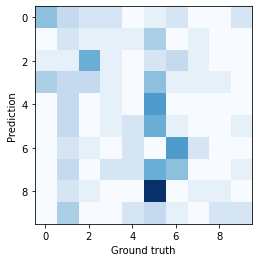

In [359]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

**Note:**
* The performance of this "fake" feature is suboptimal, although already better than some of the simplest hand-crafted features that we defined in the previous excercises.

### Frequency features (Fourier)

In [360]:
def feats_fourier(input, size=1000):
    input_ft = np.real(rfft(input))
    # Remove any values exceeding the given limit
    output = input_ft[0:min(size, input_ft.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

**Note:**
* We are fixing the size of this feature to the same arbitary length of 1000, to have a fair comparison.
* Note that we crop/pad the vector *after* computing FFT.
* Also in this case, it would be more appropriate to study the average length of the data, and select a `size` accordingly.

In [361]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_fourier, normalize=True)

In [362]:
# Verify the shape of extracted features
X_train[0].shape

(1000,)

In [363]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 14.807s


In [364]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.005


In [365]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.06      0.08        17
           1       0.06      0.10      0.07        10
           2       0.20      0.13      0.16        15
           3       0.21      0.21      0.21        19
           4       0.11      0.18      0.13        11
           5       0.00      0.00      0.00        14
           6       0.33      0.07      0.12        14
           7       0.40      0.11      0.17        19
           8       0.00      0.00      0.00        17
           9       0.13      0.57      0.21        14

    accuracy                           0.14       150
   macro avg       0.16      0.14      0.12       150
weighted avg       0.17      0.14      0.12       150



Confusion matrix:


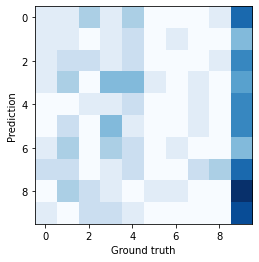

In [366]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

**Note:**
* Truncating the first 500 elements of a Fourier representation leads to unusable results.
* It is possible that this representation offers greater potential by playing with some hyperparameters.
* However, we will use it as short-time Fourier transform (a.k.a. spectrogram)

### Assignment: classification based on 2D features (Spectrogram, Mel Spectrogram, MFCC)

Approach:
1. Extract the 2-dimensional feature
2. Force the feature to have fixed size
3. Unroll the 2-dimensional feature into a 1-dimensional vector

**Hint:**
* For a given feature (e.g. Spectrogram) we still want to fix the feature length, independent of the initial audio track.
* Since now we have two dimensions (rows = frequencies, and cols = time blocks), we have to think about both.
  * The rows will be fixed by default, assuming fixed parameters for the spectrogram extraction.
  * The columns will change, based on the duration of the input track.
* Fixing the feature size *after* unrolling to 1 dimension would be easier, but it is conceptually wrong:
  * Unrolling two matrices with different columns would distribute the same frequencies in different positions in the vector.
  * This would make the classifier unable to reliably "look" for a specific sub-feature in a specific position.

### Temporal/Frequency features (spectrogram)

In [367]:
def feats_spectrogram(input, rate=8000, tsize=10):
    [spec_freqs, spec_times, spec] = spectrogram(input, fs=rate)
    if (tsize > spec.shape[1]):
      z = np.zeros((spec.shape[0], tsize-spec.shape[1]))      # dove necessario creo matrice di zeri 
      spec = np.append(spec, z, axis=1)                       # e ne faccio l'append alla matrice spec
    spec = spec[:,0:tsize]                    # ritaglio la parte interessata in funzione di tsize
    flat_spec = spec.flatten()                # vettorizzo la matrice
    output = flat_spec
    
    return output

**Note:**
* Let's use `tsize` as a parameter to control the *temporal* size, i.e. the number of columns in our 2D representation
  * This is similar to paramter `size` in the previous 1D features

In [368]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_spectrogram, normalize=True)

In [369]:
# Verify the shape of extracted features
X_train[0].shape

(1290,)

In [370]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 17.885s


In [371]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.005


In [372]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.58      0.70      0.64        10
           2       0.77      0.67      0.71        15
           3       0.65      0.58      0.61        19
           4       0.30      0.27      0.29        11
           5       0.75      0.64      0.69        14
           6       0.18      0.64      0.28        14
           7       0.67      0.32      0.43        19
           8       0.80      0.24      0.36        17
           9       0.67      0.43      0.52        14

    accuracy                           0.50       150
   macro avg       0.62      0.51      0.52       150
weighted avg       0.64      0.50      0.53       150



Confusion matrix:


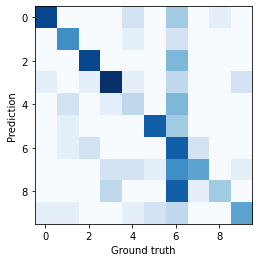

In [373]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

Tramite spettrogramma con tsize=10 si ottiene una accuracy del 50%. Le cifre 4 e 6 risultano le più problematiche: la prima per recall molto bassa e precision bassa e la seconda per precision molto bassa. Se ne deduce che il classificatore tende troppo ad eticchettare con la cifra 6 e troppo poco ad etichettare con la cifra 4. Risulta quindi che calcolare la FT su piccoli intervalli temporali dell'intera traccia è una scelta effiace.

###  Temporal/Frequency features (Mel Spectrogram)

In [374]:
def feats_mel(input, rate=8000, tsize=10):
    mel = melspectrogram(input*1.0, sr=rate)           
    if (tsize > mel.shape[1]):
      z = np.zeros((mel.shape[0], tsize-mel.shape[1]))      # dove necessario creo matrice di zeri 
      mel = np.append(mel, z, axis=1)                       # e ne faccio l'append alla matrice mel
    mel = mel[:,0:tsize]                      # ritaglio la parte interessata secondo tsize
    flat_mel = mel.flatten()                  # vettorizzo la matrice
    output = flat_mel
    
    return output

In [375]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mel, normalize=True)

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=2033
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1963
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=2007
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1976
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1987
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1886
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: U

**Note:**
* The warnings tell us that the default parameters are not fully adequate for the input size.

In [376]:
# Verify the shape of extracted features
X_train[0].shape

(1280,)

In [377]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 16.825s


In [378]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.005


In [379]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.94      0.44        17
           1       0.67      0.60      0.63        10
           2       0.64      0.60      0.62        15
           3       0.80      0.63      0.71        19
           4       0.44      0.36      0.40        11
           5       0.71      0.71      0.71        14
           6       0.62      0.36      0.45        14
           7       0.83      0.53      0.65        19
           8       0.78      0.41      0.54        17
           9       0.80      0.29      0.42        14

    accuracy                           0.55       150
   macro avg       0.66      0.54      0.56       150
weighted avg       0.67      0.55      0.56       150



Confusion matrix:


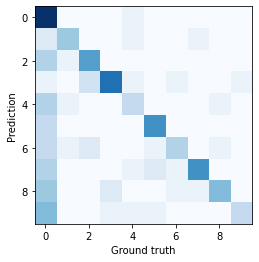

In [380]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

Tramite spettrogramma di Mel con tsize=10 si ottiene una accuracy del 55%. Le cifre 0, 4 e 9 risultano le più problematiche: le ultime due per recall molto bassa e la prima per precision molto bassa. Se ne deduce che il classificatore tende troppo ad eticchettare con la cifra 0 e troppo poco ad etichettare con la cifra 4 e 9. Rispetto al semplice spettrogramma le performance salgono di qualche punto. Questo perchè ci si concentra maggiormente sulle frequenze più basse, così come il sistema orecchio-cervello umano.

### Cepstral features (MFCC)

In [381]:
def feats_mfcc(input, rate=8000, tsize=10):
    mfccs = mfcc(input*1.0, sr=rate)              
    if (tsize > mfccs.shape[1]):
      z = np.zeros((mfccs.shape[0], tsize-mfccs.shape[1]))      # dove necessario creo matrice di zeri 
      mfccs = np.append(mfccs, z, axis=1)                       # e ne faccio l'append alla matrice mfccs
    mfccs = mfccs[:,0:tsize]                  # ritaglio la parte interessata secondo tsize
    flat_mfccs = mfccs.flatten()              # vettorizzo la matrice
    output = flat_mfccs
    
    return output

In [382]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc, normalize=True)

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=2033
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1963
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=2007
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1976
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1987
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1886
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: U

In [383]:
# Verify the shape of extracted features
X_train[0].shape

(200,)

In [384]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 5.846s


In [385]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.005


In [386]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       0.93      1.00      0.97        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



Confusion matrix:


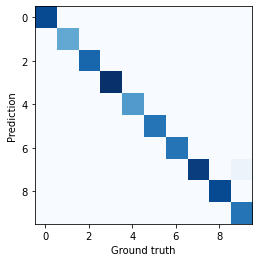

In [387]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

Tramite MFCCs con tsize=10 si ottiene una accuracy del 99%, con nessuno score riguardante le singole cifre significativamente più basso degli altri. Risultati così buoni sono molto probabilmente da inputare al fatto che nel test set sono sempre le stesse persone a pronunciare le cifre che sono state pronunciate per il training set. In definitiva questa feature risulta essere molto efficace, specie se confrontata alla precedenti.

**Note:**
* For the specific (default) parameters that we adopted in this excercise, MFCC works better than all other features.
* However, note that better performance could be obtained also for the other features, with fine tuned parameters.
  * The optimization of such parameters is not requested for the assignment.

## Assignment recap

In [388]:
def feats_spectrogram(input, rate=8000, tsize=10):
    output = input # TODO
    return output

In [389]:
def feats_mel(input, rate=8000, tsize=10):
    output = input # TODO
    return output

In [390]:
def feats_mfcc(input, rate=8000, tsize=10):
    output = input # TODO
    return output

# References

Mel spectrogram: https://www.youtube.com/watch?v=9GHCiiDLHQ4<br/>
MFCC: https://www.youtube.com/watch?v=4_SH2nfbQZ8